In [1]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

Goal: 

The goal of this project was to identify statistically cointegrated stock pairs from a set of 20 highly liquid U.S. equities and to backtest a mean-reverting pairs trading strategy based on the Engle-Granger cointegration method and Z-score signals.



Methodology:

1. Ticker Selection:

    We selected 20 of the most liquid and actively traded U.S. stocks, across sectors like tech, finance, retail, and energy. Example tickers include: AAPL, MSFT, AMZN, GOOGL, V, MA, XOM, etc.

2. Data Collection:
    We downloaded daily adjusted closing prices from Yahoo Finance for the period January 2015 to June 2025, ensuring sufficient historical depth to detect stable relationships.

3. Cointegration Test (Engle-Granger):
    + All unique stock pairs were tested using the Engle-Granger two-step method.

    + Pairs with p-values < 0.05 were considered cointegrated, indicating a stable long-term relationship despite short-term fluctuations.

4. Trading Strategy: Z-Score-Based Pairs Trading:
    + For the top cointegrated pair:

    + Hedge ratio estimated via linear regression (stock1 ~ β × stock2)

    + Spread computed: spread = stock1 - β × stock2

    + Z-score calculated over a 30-day rolling window

    + Trading rules:

        - Go long spread if z-score < -1

        - Go short spread if z-score > +1

        - Exit when z-score reverts within ±0.5

    + Daily returns were calculated assuming a dollar-neutral position.



In [2]:
# 1. Define 20 liquid tickers
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META',
    'NVDA', 'TSLA', 'JPM', 'UNH', 'V',
    'MA', 'HD', 'DIS', 'PEP', 'MCD',
    'XOM', 'CVX', 'WMT', 'BAC', 'NFLX'
]

# 2. Download daily adjusted close prices
data = yf.download(tickers, start='2015-01-01', end='2025-06-01', auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    data = data['Close']  # Only extract Close level
data.columns = [col.upper() for col in data.columns]

data = data.dropna()


# 3. Run Engle-Granger test on all unique pairs
cointegrated_pairs = []

for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        s1 = data[tickers[i]]
        s2 = data[tickers[j]]
        score, pvalue, _ = coint(s1, s2)
        if pvalue < 0.05:
            cointegrated_pairs.append((tickers[i], tickers[j], pvalue))

# 4. Sort and display top results
cointegrated_pairs.sort(key=lambda x: x[2])
top_pairs = pd.DataFrame(cointegrated_pairs[:10], columns=['Stock 1', 'Stock 2', 'p-value'])

print("Top Cointegrated Pairs (p < 0.05):\n")
print(top_pairs)


[*********************100%***********************]  20 of 20 completed


Top Cointegrated Pairs (p < 0.05):

  Stock 1 Stock 2   p-value
0       V      MA  0.001215
1   GOOGL      HD  0.004587
2    AAPL      HD  0.009877
3    TSLA      HD  0.010231
4    META     JPM  0.016935
5    TSLA     MCD  0.019885
6     UNH     PEP  0.022079
7    MSFT   GOOGL  0.023700
8     JPM     WMT  0.024232
9    TSLA      MA  0.036960


[*********************100%***********************]  2 of 2 completed


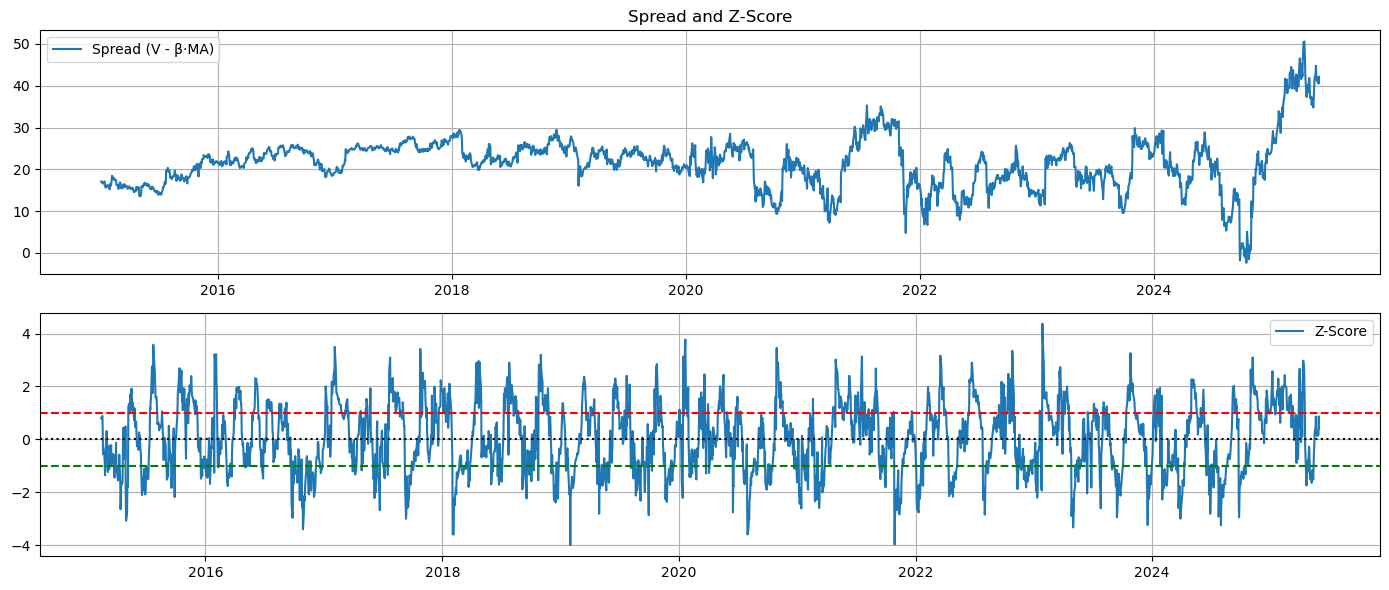

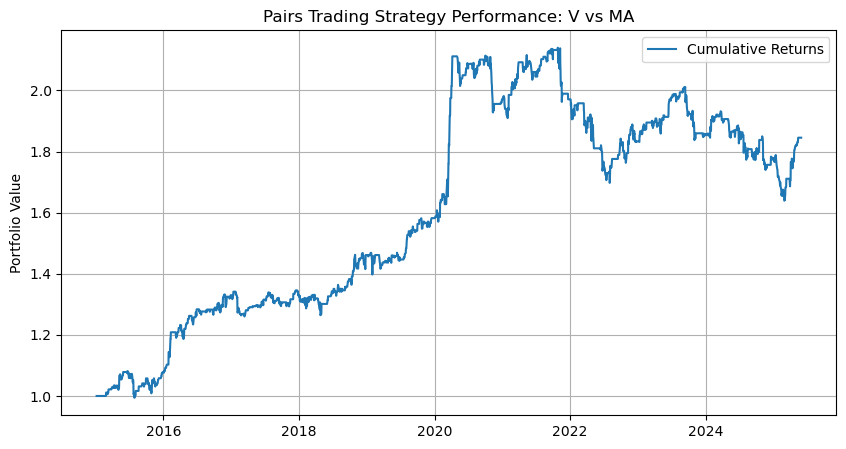


 Strategy Summary:

Total Return           0.8455
Annualized Sharpe      0.6650
Trades Executed      289.0000
dtype: float64


In [3]:
# Step 1: Download Price Data
tickers = ['V', 'MA']
data = yf.download(tickers, start='2015-01-01', end='2025-06-01', auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    data = data['Close']
data.columns = [col.upper() for col in data.columns]
data = data.dropna()


# Step 2: Estimate Hedge Ratio

Y = data['V']
X = data['MA']
X_const = sm.add_constant(X)
model = sm.OLS(Y, X_const).fit()
hedge_ratio = model.params['MA']


# Step 3: Compute Spread & Z-Score

spread = Y - hedge_ratio * X
zscore = (spread - spread.rolling(30).mean()) / spread.rolling(30).std()


# Step 4: Generate Trading Signals

signals = pd.DataFrame(index=spread.index)
signals['zscore'] = zscore
signals['position'] = 0
signals.loc[zscore > 1, 'position'] = -1  # short V, long MA
signals.loc[zscore < -1, 'position'] = 1   # long V, short MA
signals.loc[abs(zscore) < 0.5, 'position'] = 0  # exit
signals['position'] = signals['position'].ffill()


# Step 5: Compute Strategy Returns

returns = data.pct_change().dropna()
signals = signals.loc[returns.index]
pnl = signals['position'].shift(1) * (returns['V'] - hedge_ratio * returns['MA'])
cum_pnl = (1 + pnl).cumprod()


# Step 6: Plot Results

plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(spread, label='Spread (V - β·MA)')
plt.title('Spread and Z-Score')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(zscore, label='Z-Score')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(0, color='black', linestyle=':')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cum_pnl, label='Cumulative Returns')
plt.title('Pairs Trading Strategy Performance: V vs MA')
plt.ylabel('Portfolio Value')
plt.grid()
plt.legend()
plt.show()


# Step 7: Summary Metrics

sharpe = (pnl.mean() / pnl.std()) * np.sqrt(252)
total_return = cum_pnl.iloc[-1] - 1
num_trades = (signals['position'].diff().abs() > 0).sum() // 2

summary = pd.Series({
    'Total Return': total_return,
    'Annualized Sharpe': sharpe,
    'Trades Executed': num_trades
})

print("\n Strategy Summary:\n")
print(summary.round(4))


Top Panel: The spread between V - β×MA remained relatively mean-reverting but became more volatile after 2020.

Bottom Panel: The z-score oscillates frequently, crossing trading thresholds (±1) regularly. This suggests the pair offers many opportunities to enter long/short positions as the spread deviates and reverts.

Thresholds used:

+ Entry: ±1

+ Exit: 0.5

The second chart illustrates the cumulative returns of the strategy:

+ The strategy grows capital from an initial value of 1.0 to over 1.84, representing an 84.5% cumulative return over the 10-year backtest period.

+ Notably strong growth occurred between 2019 and early 2021, followed by more mean-reverting (sideways) behavior.



Interpretation: 

+ The strategy consistently identified mean-reverting signals, with nearly 300 trade cycles over the decade.

+ An annualized Sharpe Ratio of 0.665 indicates moderate risk-adjusted performance.




Conclusion:

The backtest confirms that Visa and Mastercard form a statistically and economically viable pair for mean-reversion trading. With proper execution and risk control, this pairs trading setup could serve as a low-beta, market-neutral strategy within a diversified portfolio.